In [38]:
import csv
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

Let's go ahead and modify our existing build_graph function to weight our graphs edges. We'd like for edges linking nodes whose musical attributes are "close" to one another (whatever that means) to be more heavily weighted than edges where the influcing artists has not seemingly passed on their unique musical attributes to the influenced. 
So, just how are we going to measure attribute similarity? One very na&iuml;ve way is to assume that each attribute, let's call them a and b, can attain some maximum value $L$ and then calculaute 
$$
    sim(a, b) = 1 - \frac{|a-b|}{L}
$$
In the case of danceability, energy, acousticness, instrumentalness, liveness, speechiness and valence we're lucky and $L=1$. For loudness we turn to 2021_ICM_Problem_D.pdf and note that loudness ranges from 0db to -60db. I went ahead and considered the maximum value of loudness to be |-60db|. If $sim(a,b) > 0.9$ I added a "point" of weight to the edge. Where did this threshold come from, I haven't the faintest. 
Is this the one true way to measure how close are attributes are? Of course it isn't! This is all a proof of concept and we can substitute whatever methods we like in lines 46 to 69 of the function build_weighted_graph. 

In [82]:
def build_weighted_graph(inf_data, artist_data):
    """
    Returns the directed graph of artistic influeence taken from influence_data.csv
       
    Parameters
    ----------
    inf_data : the file influence_data.csv
    arist_data : the file data_by_artist.csv
    
    Returns
    -------
    graph : a NetworkX directed graph

    Notes
    -----
    """
    graph = nx.DiGraph()
    for row in inf_data:
        # Here we add our artists to our graph.
        if graph.has_node(row[0]) is False:	
            graph.add_node(row[0], name = row[1], genre = row[2], active_start = row[3] )
        if graph.has_node(row[4]) is False:
            graph.add_node(row[4], name = row[5], genre = row[6], active_start = row[7])
        # Here we add edges from the influenced artist to their influencer.
        graph.add_edge(row[4],row[0])
    # Here we attach musical attributes to our artists
    for row in artist_data:
        for node in graph:
            if row[1] == node:
                graph.nodes[node]["danceability"] = row[2]
                graph.nodes[node]["energy"] = row[3]
                graph.nodes[node]["valence"] = row[4]
                graph.nodes[node]["tempo"] = row[5]
                graph.nodes[node]["loudness"] = row[6]
                graph.nodes[node]["key"] = row[8]
                graph.nodes[node]["acousticness"] = row[9]
                graph.nodes[node]["instrumentalness"] = row[10]
                graph.nodes[node]["liveness"] = row[11]
                graph.nodes[node]["speechiness"] = row[12]
                graph.nodes[node]["duration_ms"] = row[13]
                graph.nodes[node]["popularity"] = row[14]
                graph.nodes[node]["count"] = row[15]
    # We loop through our nodes, gather their edges, and weight them. 
    for node in graph:
            out_edges = graph.out_edges(node)
            for edge in out_edges:
                new_edge_weight = 0
                dance_sim = 1 - abs(float(graph.nodes[edge[0]]["danceability"])-float(graph.nodes[edge[1]]["danceability"]))
                energy_sim = 1 - abs(float(graph.nodes[edge[0]]["energy"])-float(graph.nodes[edge[1]]["energy"]))
                valence_sim = 1 - abs(float(graph.nodes[edge[0]]["valence"])-float(graph.nodes[edge[1]]["valence"]))
                loud_sim = 1 - abs(float(graph.nodes[edge[0]]["loudness"])-float(graph.nodes[edge[1]]["loudness"]))/60
                acoust_sim = 1 - abs(float(graph.nodes[edge[0]]["acousticness"])-float(graph.nodes[edge[1]]["acousticness"]))
                inst_sim = 1 - abs(float(graph.nodes[edge[0]]["instrumentalness"])-float(graph.nodes[edge[1]]["instrumentalness"]))
                speech_sim = 1 - abs(float(graph.nodes[edge[0]]["speechiness"])-float(graph.nodes[edge[1]]["speechiness"]))
                if dance_sim > 0.9:
                    new_edge_weight += 1
                if energy_sim > 0.9:
                    new_edge_weight += 1
                if valence_sim > 0.9:
                    new_edge_weight += 1
                if loud_sim > 0.9:
                    new_edge_weight += 1
                if acoust_sim > 0.9:
                    new_edge_weight += 1
                if inst_sim > 0.9:
                    new_edge_weight += 1
                if speech_sim > 0.9:
                    new_edge_weight += 1
                graph[edge[0]][edge[1]]["weight"] = new_edge_weight
                
    # Is our graph an acyclic directed graph
    print("Our graph is an acyclic directed graph: " + str(nx.is_directed_acyclic_graph(graph)))

    # Check nodes
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    # Is this really the number of edges, I know that our graph is not acyclic but if it were there should be
    # n*(n-1)/2 edges, no?
    num_possible_edges = num_nodes*(num_nodes - 1)
    print("Our artistic influence network has " + str(num_nodes)+" artists.")
    print("Our artistic influence network has " + str(num_edges)+" edges out of a possible " + str(num_possible_edges) + " possible edges.")
    print("Our network density is: " + str(nx.density(graph)))

    return graph

Our full data set is quite the handful so let's work with a small subset as a proof of concept. The subset of our infleunce data contained in the file test_digraph.csv contains 23 artists and their relationships. It's easy to troubleshoot and it's easy to visualize a smaller graph. 

In [23]:
# As a csv.reader is an expendible resource we write the lines of our csv file to a list
with open("test_digraph.csv", "rt") as infile:
        reader = csv.reader(infile)
        # We discard the column labels as they are unneccesary 
        next(reader)
        influence_data = list(reader)

In [31]:
# As a csv.reader is an expendible resource we write the lines of our csv file to a list
with open("data_by_artist.csv", "rt") as infile:
        reader = csv.reader(infile)
        # We discard the column labels as they are unneccesary 
        next(reader)
        artist_data = list(reader)

In [83]:
g = build_weighted_graph(influence_data, artist_data)

Our graph is an acyclic directed graph: True
Our artistic influence network has 23 artists.
Our artistic influence network has 21 edges out of a possible 506 possible edges.
Our network density is: 0.041501976284584984


We now going to plot our graph with our new edgeweights listed on the edge. The artists are referred to by their influencer_id (e.g. PJ Harvey is node 335). 

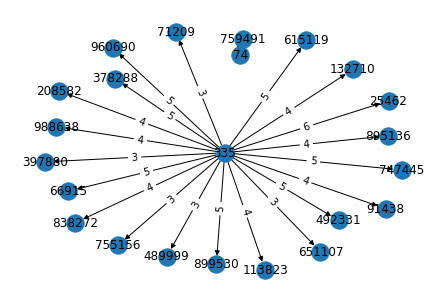

In [84]:
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels = True)
labels = {e: g.edges[e]["weight"] for e in g.edges}
nx.draw_networkx_edge_labels(g, pos, edge_labels = labels)
plt.show()